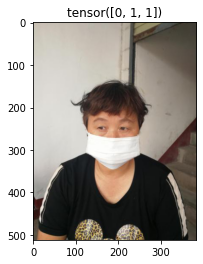

torch.Size([512, 384, 3])


In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import os

class MaskDataSet(torch.utils.data.Dataset):
    def __init__(self,csv_file,root_dir,transform=None):
        self.root_dir=pathlib.Path(root_dir)
        self.transform=transform
        # 기존의 train.csv의 path값을 참조해 파일 path를 반환
        self.file_path = self.read_csv_file(csv_file,self.root_dir)
    
    def __len__(self):
        return len(self.file_path)    
    
    def __getitem__(self,idx):
        gender_labeling={
            'male':0,
            'female':1
        }
        age_labeling={
            10:0,
            20:0,
            30:1,
            40:1,
            50:1,
            60:2
        }
        mask_labeling={
            'mask':0,
            'inco':1,
            'norm':2
        }
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # image data 불러오기
        img_path = self.root_dir/self.file_path[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # label data 생성
        file_folder,file_name= str(self.file_path[idx]).split('/')
        _,gender,_,age = file_folder.split('_')
        age = int(age)//10*10
        wear = file_name.split('.')[0][:4]
        y = np.array([mask_labeling[wear], gender_labeling[gender], age_labeling[age]])
            
        return torch.tensor(np.array(image)),torch.tensor(y)
    
    def read_csv_file(self,csv_file,root_dir):
        ''' Return file path using directory path in csv_file  '''
        FILE_SUFFIX = ['incorrect_mask','mask1','mask2','mask3','mask4','mask5','normal']
        # directory path 불러오기
        mask_pd = pd.read_csv(csv_file)
        # 각 directory path 안에 있는 파일 이름을 저장(확장자명 포함 X)
        suffixed_path = [pathlib.Path(path,suffix) for path in mask_pd['path'] for suffix in FILE_SUFFIX]
        # file path에서 확장자 명을 붙여준다.
        # directory path에서 내부 파일의 확장자 명을 확인
        image_extended = [next((root_dir/path).parent.glob(path.parts[-1]+'*')).suffix for path in suffixed_path]
        # file path에 확장자명을 붙여서 Serise 객체로 반환
        return pd.Series([str(s_path) + i_ext for s_path,i_ext in zip(suffixed_path,image_extended)])
        

if __name__ =='__main__':
    data=MaskDataSet('input/data/train/train.csv','input/data/train/images')
    loader = torch.utils.data.DataLoader(data,batch_size=128,shuffle=True)
    x, y = next(iter(loader))
    plt.imshow(x[0])
    plt.title(y[0])
    plt.show()
    print(x[0].shape)

# target class distribution

In [2]:
from tqdm import tqdm
class_num = np.array([0]*18)
data=MaskDataSet('input/data/train/train.csv','input/data/train/images')
loader = torch.utils.data.DataLoader(data,batch_size=128)
for _,batch_y in tqdm(loader):
    numpy_y = batch_y.detach().cpu().numpy()
    numpy_y[:,0] = numpy_y[:,0]*6
    numpy_y[:,1]= numpy_y[:,1]*3
    
    for index in numpy_y.sum(axis=1):
        class_num[index]+=1

100%|█████████████| 148/148 [01:37<00:00,  1.53it/s]


In [3]:
class_num

array([2745, 2050,  415, 3660, 4085,  545,  549,  410,   83,  732,  817,
        109,  549,  410,   83,  732,  817,  109])

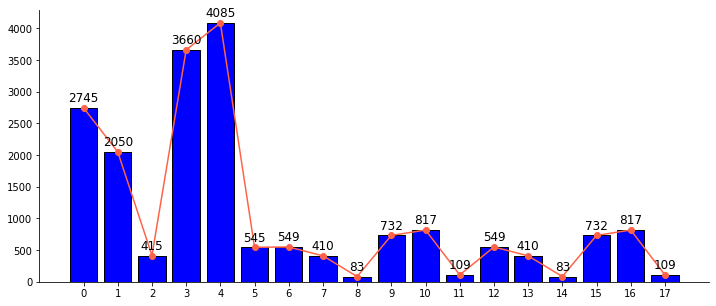

In [4]:
fig,ax = plt.subplots(figsize=(12,5))
ax.bar(range(len(class_num)),class_num,edgecolor='black',color='blue')
ax.plot(range(len(class_num)),class_num,marker='o',color='tomato',linewidth=1.5)
ax.set_xticks(range(len(class_num)))

for idx,data in enumerate(class_num):
    ax.text(idx,data+100,data,ha='center',fontsize=12)

for spine in ['top','right']:
    ax.spines[spine].set_visible(False)
    

plt.show()

# Data Augmentation

In [6]:
import torchvision
normal_data = MaskDataSet('input/data/train/train.csv','input/data/train/images')

resized1_trsfm = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224,224))])
resized1_data = MaskDataSet('input/data/train/train.csv','input/data/train/images',transform=resized1_trsfm)

resized2_trsfm = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor()])
resized2_data = MaskDataSet('input/data/train/train.csv','input/data/train/images',transform=resized2_trsfm)


normalized_trsfm = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0,0.5)])
normalized_data = MaskDataSet('input/data/train/train.csv','input/data/train/images',transform=normalized_trsfm)

full_trsfm = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.Normalize(0,0.5),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.RandomCrop((112,112)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.GaussianBlur(kernel_size=(7,7)),
    torchvision.transforms.RandomErasing(),
])
full_data = MaskDataSet('input/data/train/train.csv','input/data/train/images',transform=full_trsfm)


In [7]:
data = [normal_data,resized1_data,resized2_data,normalized_data,full_data]
for datum in data:
    print('='*50)
    print('current model :',datum)
    loader = torch.utils.data.DataLoader(datum,shuffle=True,batch_size=128)
    for _,_ in tqdm(loader):
        pass

  0%|                       | 0/148 [00:00<?, ?it/s]

current model : <__main__.MaskDataSet object at 0x7fcc7cdd6820>


  0%|                       | 0/148 [00:00<?, ?it/s]

current model : <__main__.MaskDataSet object at 0x7fcc7d69c880>


  0%|                       | 0/148 [00:00<?, ?it/s]

current model : <__main__.MaskDataSet object at 0x7fcc7cddd280>


  0%|                       | 0/148 [00:00<?, ?it/s]

current model : <__main__.MaskDataSet object at 0x7fcc7cae6550>


  0%|                       | 0/148 [00:00<?, ?it/s]

current model : <__main__.MaskDataSet object at 0x7fcc7d3fe9d0>


100%|█████████████| 148/148 [02:14<00:00,  1.10it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


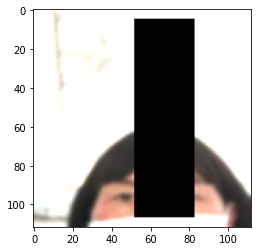

In [8]:
loader= torch.utils.data.DataLoader(full_data,shuffle=True,batch_size=128)
x,y = next(iter(loader))
numpy_x = x[0].permute(1,2,0).detach().cpu().numpy()
plt.imshow(numpy_x)